Import the packages.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.cross_validation import cross_val_score

/home/bsknight/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Read in the data and extract features from labels. 

In [2]:
df = pd.read_csv('./Data/munged_df.csv', index_col='account_id')
feature_cols = list(df.columns[:-1])
target_col = df.columns[-1] 
X_all = df[feature_cols]
y_all = df[target_col] 

In [3]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_all = scaler.fit_transform(X_all)

In [21]:
from sklearn.cross_validation import train_test_split

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all , 
                                                    y_all, 
                                                    stratify=y_all,
                                                    test_size=0.1, 
                                                    random_state=1)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 14946 samples.
Testing set has 1661 samples.


In [5]:
def svccv(C, gamma):
    return cross_val_score(SVC(C=C, gamma=gamma, random_state=1, kernel='rbf'),
                           X_train, y_train, 'recall_weighted', cv=20, n_jobs=-1).mean()

if __name__ == "__main__":
    gp_params = {"alpha": 1e5}

    svcBO = BayesianOptimization(svccv, {'C': (0.0001, 1000), 'gamma': (0.0001, 1000)})
    svcBO.explore({'C': [0.001, 0.01, 0.1], 'gamma': [0.001, 0.01, 0.1]})

    svcBO.maximize(n_iter=10, **gp_params)
    print('SVC: %11.9f' % svcBO.res['max']['max_val'])


Initialization
-----------------------------------------------------
 Step |   Time |      Value |         C |     gamma | 
    1 | 01m59s |    0.93978 |    0.0010 |    0.0010 | 
    2 | 05m13s |    0.93978 |    0.0100 |    0.0100 | 
    3 | 20m55s |    0.93978 |    0.1000 |    0.1000 | 
    4 | 58m29s |    0.94025 |  716.6030 |  144.6162 | 
    5 | 62m49s |    0.94025 |  183.8353 |  554.3573 | 
    6 | 60m34s |    0.94025 |  346.2878 |  172.9417 | 
    7 | 63m29s |    0.94025 |  298.6743 |  572.8721 | 
    8 | 56m29s |    0.94025 |  163.0481 |   61.1648 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         C |     gamma | 
    9 | 63m04s |    0.94025 |  999.3418 |  999.8306 | 
   10 | 63m49s |    0.94025 |  999.4703 |  993.9435 | 
   11 | 64m27s |    0.94025 |  996.6511 |  999.7468 | 
   12 | 64m30s |    0.94025 |  995.6641 |  997.7987 | 
   13 | 64m35s |    0.94025 |  998.4679 |  999.7328 | 
   14 | 45m40s |    0.94025 | 

In [12]:
results = svcBO.res['max']
rbf_gamma = results['max_params']['gamma']
rbf_C = results['max_params']['C']
print(rbf_C)
print(rbf_gamma)

716.602971784
144.616158489


In [ ]:
# c = 716.602971784
# gama = 144.616158489

In [7]:
clf = SVC(C=rbf_C, cache_size=200, gamma=rbf_gamma, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
from sklearn.metrics import precision_recall_curve
y_score = clf.fit(X_train, y_train).decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

In [19]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

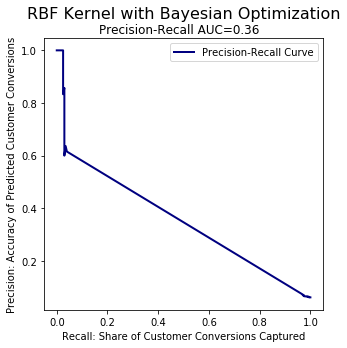

In [20]:
lw = 2
plt.figure(figsize=(5,5))
plt.plot(recall, precision, lw=lw, color='navy', label='Precision-Recall Curve')
plt.legend(loc="upper right")
plt.xlabel('Recall: Share of Customer Conversions Captured')
plt.ylabel('Precision: Accuracy of Predicted Customer Conversions')
plt.title('RBF Kernel with Bayesian Optimization', y=1.05, fontsize=16)
plt.suptitle('Precision-Recall AUC={0:0.2f}'.format(average_precision), y=0.92, fontsize=12)
# plt.show()
path = '/home/bsknight/Documents/Personal_Training_Git/Udacity/Udacity-Machine_Learning_Nanodegree/' + \
       'Capstone_Project/Images'
savepath = os.path.join(path, 'optimized_SVM_with_RBF.png')
plt.savefig(savepath)
plt.clf()

In [11]:
a = pd.DataFrame(recall)
a.rename(columns={0: 'recall'}, inplace=True)
b = pd.DataFrame(precision)
b.rename(columns={0: 'precision'}, inplace=True)
results = pd.concat([a, b], axis=1) 
path = '/home/bsknight/Documents/Personal_Training_Git/Udacity/Udacity-Machine_Learning_Nanodegree/' + \
       'Capstone_Project'
results.to_csv("Optimized_RBF_Kernel_Results.csv")